<span>
<img src="img/cdlib_new.png" width="120px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.7<br/>
<b>CDlib version:</b>  0.1.10<br/>
<b>Last update:</b> 16/02/2021
</span>

In [1]:
import warnings
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import cdlib
from cdlib import algorithms
from cdlib import ensemble as en
from cdlib import evaluation as evaluation
from cdlib import viz
warnings.filterwarnings('ignore')

In [2]:
def mesure_graph(DG):
    print('The Network DG has:\n Number of Nodes = ',DG.number_of_nodes(),'\n Number of Edges = ',DG.number_of_edges(),'\n')
    print('Average degree of "edges, links" = ',sum(dict(DG.degree()).values())/float(len(DG)))
    print('Is a Directed Network ?',DG.is_directed())

<a id='top'></a>
# Cap 8:Community Discovery*

In this notebook are introduced the main steps for the extraction and topological analysis of communities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available in ``CDlib``, please refer to the official [documentation](https://cdlib.readthedocs.io) and the dedicated notebook appendix.

## Table of Contents

1. [Community Discovery Workflow](#workflow)
    1. [Dataframe for Direct and Undirect graph](#datarame)
    1. [Graph Creation](#graph)
    2. [Community Discovery algorithm(s) selection and configuration ](#model)
    3. [Clustering Evaluation (Fitness functions)](#fitness)
    4. [Clustering Evaluation (Comparison)](#comparison)
    5. [Community/Statistics Visualization](#visualization)
    6. [Qualitative evaluation](#qualitative)
    7. [Ground Truth evaluation](#gt)
    8. [Advanced facilities: Pooling and Optimization](#advanced)

<a id="dataframe"></a>
### Dataframe for Direct and Undirect graph ([to top](#top))

### Data for Direct graph


In [3]:
df = pd.read_csv("scraping data/data/data_subreddit_direct.csv",index_col=0)

df1=df.copy()
#delete the columns 
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df.head()


,parent,to,interactions,crossposts,weights
0,nature,environment,1746.0,1,7.465655
1,nature,EcoNewsNetwork,154.0,13,5.043425
2,nature,PublicLands,3.0,1,1.386294
3,nature,EndangeredSpecies,28.0,2,3.367296
4,nature,animalimpact,5.0,3,1.791759


### Directed Graph
The name of indirected Graph is "dfg"

### Data for Undirect graph

In [4]:
dfg = pd.read_csv("scraping data/data/data_subreddit_Undirect.csv",index_col=0)

dfg1=dfg.copy()
#delete the columns 
columns2remove = ['date']
dfg.drop(columns2remove, inplace=True, axis=1)
dfg.head()


,parent,to,interactions,crossposts,weights
0,nature,environment,1965.0,3,7.583756
1,nature,EcoNewsNetwork,292.0,18,5.680173
2,nature,PublicLands,3.0,1,1.386294
3,nature,EndangeredSpecies,28.0,2,3.367296
4,nature,animalimpact,5.0,3,1.791759


<a id='workflow'></a>
## Community Discovery Workflow ([to top](#top))

The standard workflow can be summarized as:
- Network Creation
- Community Discovery algorithm(s) selection and configuration
- Clustering(s) evaluation (Fitness functions)
- Clustering(s) evaluation (Comparisons)
- Community/Statistics Visualization

In this section we will observe how to templating such workflow applying two classic network clustering algorithms: Label Propagation and Leiden.
All analysis will be performed using ``CDlib``.

<a id="graph"></a>
### Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``CDlib`` natively supports both [``networkx``](https://networkx.github.io) and [``igraph``](https://igraph.org/python/) data structures.

In our examples, for the sake of simplicity, we will use ``networkx`` undirected graphs. 

### Undirected Graph
The name of indirected Graph is "g"

In [5]:
g=[]
g = nx.from_pandas_edgelist(dfg, source='parent', target='to',
                                     edge_attr=['crossposts', 'weights'],
                                     create_using=nx.Graph())
mesure_graph(g)

The Network DG has:
 Number of Nodes =  24819 
 Number of Edges =  104284 

Average degree of "edges, links" =  8.403561787340344
Is a Directed Network ? False


### Directed Graph
The name of indirected Graph is "dg"

In [6]:
dg=[]

dg = nx.from_pandas_edgelist(df, source='parent', target='to',
                                     edge_attr=['crossposts', 'weights'],
                                     create_using=nx.DiGraph)
mesure_graph(dg)

The Network DG has:
 Number of Nodes =  24819 
 Number of Edges =  107094 

Average degree of "edges, links" =  8.63000120875136
Is a Directed Network ? True


<a id="model"></a>
### Community Discovery algorithm(s) selection and configuration ([to top](#top))

After having defined the graph, we can select the algorithm(s) to partition it.

### Leiden
Community Discovery algorithm selection and configuration 

In [7]:
leiden_coms = algorithms.leiden(g,weights='crossposts')

All Community Discovery algorithms generate as result an object that implements a concrete instance of the ``Clustering`` datatype.
In particular, both Louvain and Label Propagation returns a ``NodeClustering`` object having the following propterties:

In [8]:
print('Clustering algorithm name is',leiden_coms.method_name,'\n') 
print('Clustering parameters',leiden_coms.method_parameters)


Clustering algorithm name is Leiden 

Clustering parameters {'initial_membership': None, 'weights': 'crossposts'}


In [9]:
Leiden_clusters=leiden_coms.communities # Identified Clustering


In [10]:
print('Wehter the clustering is overlapping or not = ',leiden_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',leiden_coms.node_coverage,'\n') 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



Moreover, ``Clustering`` object allow also for the generation of a JSON representation of the results

In [11]:
Leiden_comunity_js=leiden_coms.to_json()

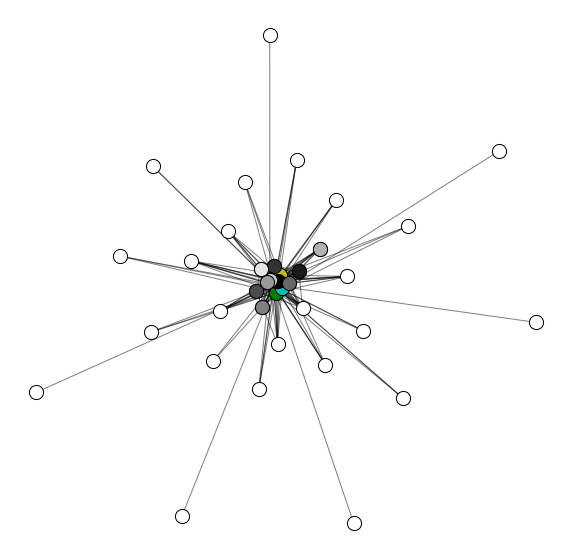

In [12]:
from cdlib import viz
viz.plot_community_graph(g, leiden_coms, figsize=(10, 10))

## Louvain
Community Discovery algorithm selection and configuration 

##### Optimal Search Louvain

In [16]:
resolution = en.Parameter (name="resolution", start=0.1, end=1 , step =0.1 )
randomize = en.BoolParameter(name="randomize")
louvain_conf = [resolution, randomize]

# Optimal Search Louvain
[louv_comunity,louv_mod]= en.grid_search(graph=g , method= algorithms.louvain,
parameters =[resolution,randomize], quality_score = evaluation.erdos_renyi_modularity ,aggregate=max)
print(louv_comunity,louv_mod)

<cdlib.classes.node_clustering.NodeClustering object at 0x000002878547AA48> FitnessResult(min=None, max=None, score=0.5077293770734774, std=None)


In [17]:
print('Clustering algorithm name is',louv_comunity.method_name,'\n') 
print('Clustering parameters',louv_comunity.method_parameters)
louv_comunity

Clustering algorithm name is Louvain 

Clustering parameters {'weight': 'weight', 'resolution': 0.9, 'randomize': True}


Clustering algorithm name is Louvain 

Clustering parameters {'weight': 'crossposts', 'resolution': 0.9, 'randomize': True}
Identified Clustering with "Louvain", 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



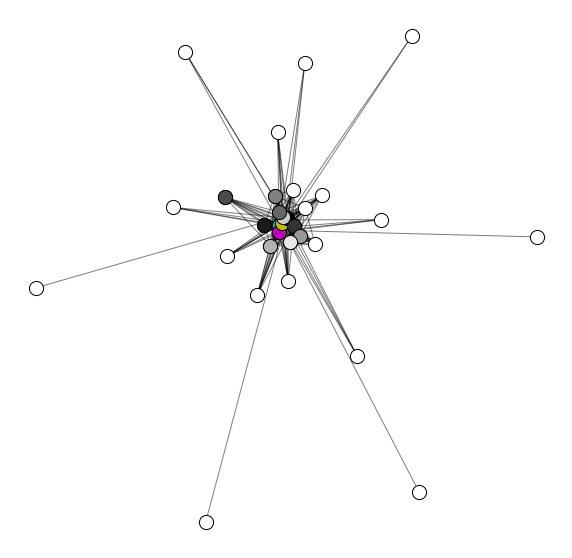

In [25]:
louv_coms = algorithms.louvain(g, weight='crossposts',resolution=0.9,randomize=True)

print('Clustering algorithm name is',louv_coms.method_name,'\n') 
print('Clustering parameters',louv_coms.method_parameters)
print('Identified Clustering with "Louvain", \n')

louv_clusters=louv_coms.communities 

print('Wehter the clustering is overlapping or not = ',louv_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',louv_coms.node_coverage,'\n') 

louv_comunity_js=louv_coms.to_json()

viz.plot_community_graph(g, louv_coms, figsize=(10, 10))

### Label Propagation
Community Discovery algorithm selection and configuration 

Clustering algorithm name is Label Propagation 

Clustering parameters {'': ''}
Identified Clustering with "Label Propagation", 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



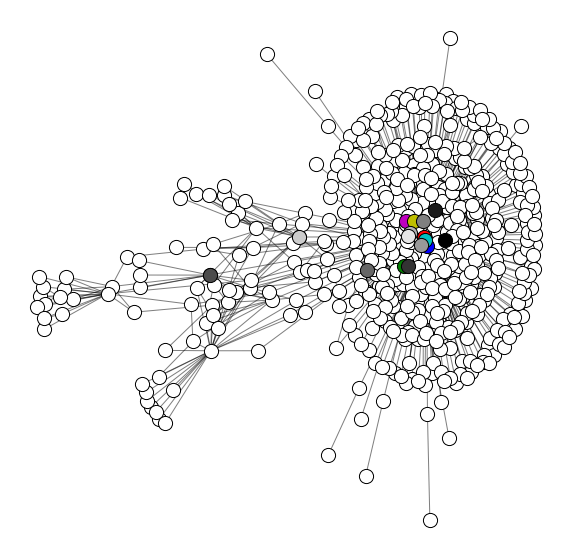

In [26]:
lp_coms = algorithms.label_propagation(g)

print('Clustering algorithm name is',lp_coms.method_name,'\n') 
print('Clustering parameters',lp_coms.method_parameters)
print('Identified Clustering with "Label Propagation", \n')

lp_clusters=lp_coms.communities 

print('Wehter the clustering is overlapping or not = ',lp_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',lp_coms.node_coverage,'\n') 

lp_comunity_js=lp_coms.to_json()

viz.plot_community_graph(g, lp_coms, figsize=(10, 10))

### Demon

##### Optimal Search Demon

In [20]:
eps = en.Parameter(name="epsilon", start=0.1 , end=1 , step =0.1 )
min_coms=en.Parameter(name="min_com_size", start=3, end=9, step=3)

demon_conf = [eps]

# Optimal Search Louvain
[demon_comunity,demon_scoring]= en.grid_search(graph=g , method= algorithms.demon,
parameters =[eps,min_coms], quality_score = evaluation.erdos_renyi_modularity ,aggregate=max)


In [21]:

print(demon_comunity,demon_scoring)
print('Clustering algorithm name is',demon_comunity.method_name,'\n') 
print('Clustering parameters',demon_comunity.method_parameters)
louv_comunity

<cdlib.classes.node_clustering.NodeClustering object at 0x000002878B32FC88> FitnessResult(min=None, max=None, score=8.434526392589117, std=None)
Clustering algorithm name is DEMON 

Clustering parameters {'epsilon': 0.9, 'min_com_size': 3}


In [27]:
demon_coms = algorithms.demon(g, min_com_size=3,epsilon=0.9)

print('Clustering algorithm name is',demon_coms.method_name,'\n') 
print('Clustering parameters',demon_coms.method_parameters)
print('Identified Clustering with "Label Propagation", \n')

demon_clusters=demon_coms.communities 

print('Wehter the clustering is overlapping or not = ',demon_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',demon_coms.node_coverage,'\n') 

#demon_comunity_js=demon_coms.to_json()

#viz.plot_community_graph(g, demon_coms, figsize=(10, 10))

Clustering algorithm name is DEMON 

Clustering parameters {'epsilon': 0.9, 'min_com_size': 3}
Identified Clustering with "Label Propagation", 

Wehter the clustering is overlapping or not =  True 

Percentage of nodes covered by the clustering =  0.38575285063862363 



### Infomap
Community Discovery algorithm selection and configuration 

Clustering algorithm name is Infomap 

Clustering parameters {'': ''}
Identified Clustering with "infomap": 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



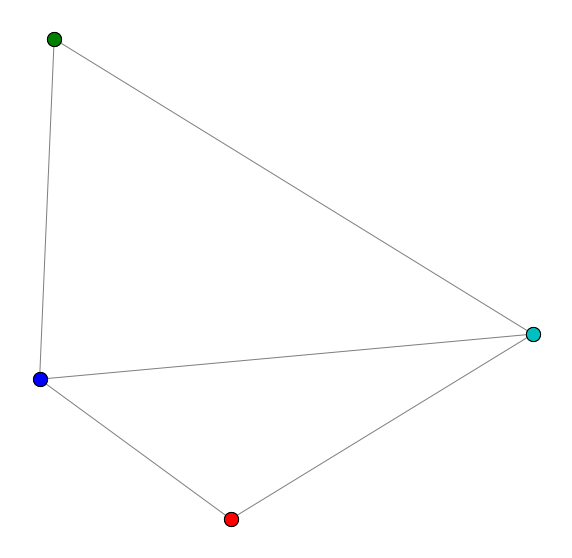

In [28]:
info_coms = algorithms.infomap(g)

print('Clustering algorithm name is',info_coms.method_name,'\n') 
print('Clustering parameters',info_coms.method_parameters)

info_clusters=info_coms.communities 
print('Identified Clustering with "infomap": \n')
print('Wehter the clustering is overlapping or not = ',info_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',info_coms.node_coverage,'\n') 

info_comunity_js=info_coms.to_json()

viz.plot_community_graph(g, info_coms, figsize=(10, 10))

<a id="fitness"></a>
### Clustering Evaluation (Fitness functions) ([to top](#top))

After having obtained a network clustering we can compute several indexes upon it. 

For a same index it is possible to obtain a synthetic representation of its min/max/mean/std values

### Leiden
Clustering Evaluation (Fitness functions)

In [29]:
leiden_fit=leiden_coms.average_internal_degree()
print('Internal degree:\n', leiden_fit)


Internal degree:
 FitnessResult(min=1.0, max=8.121065375302663, score=3.0128480097913943, std=1.5523114584882667)


as well as its communitiy-wise value

In [30]:
Leiden_in_degree=leiden_coms.average_internal_degree(summary=False)
print('Average Internal grade comunities with Leiden: \n',Leiden_in_degree)


Average Internal grade comunities with Leiden: 
 [5.383232362712527, 5.876210032267527, 4.174812700677845, 5.074915824915825, 3.4177949709864603, 5.190891472868217, 5.949914627205464, 8.121065375302663, 3.3316708229426433, 4.291729323308271, 3.2135728542914173, 2.4448979591836735, 2.6610169491525424, 3.312320916905444, 4.257731958762887, 2.502923976608187, 2.537313432835821, 2.054054054054054, 1.9428571428571428, 2.4545454545454546, 1.8823529411764706, 2.75, 1.8666666666666667, 2.4, 2.4285714285714284, 3.857142857142857, 1.8333333333333333, 2.0, 2.0, 1.75, 4.857142857142857, 1.7142857142857142, 1.7142857142857142, 1.6666666666666667, 1.6666666666666667, 2.3333333333333335, 1.6, 1.5, 1.5, 1.0]


Fitness scores can also be instantiated at library level

For the complete list of implemented fitness functions, refer to the online [documentation](https://cdlib.readthedocs.io/en/latest/reference/evaluation.html).

### Louvain
Clustering Evaluation (Fitness functions)

In [31]:
louv_fit=louv_coms.average_internal_degree()
print('Internal degree:\n',louv_fit)
louv_in_degree=louv_coms.average_internal_degree(summary=False)
print('\n Average Internal grade comunities with Louvain: \n\n',louv_in_degree)

Internal degree:
 FitnessResult(min=1.5, max=8.026737967914439, score=3.203972549047281, std=1.5022583106238292)

 Average Internal grade comunities with Louvain: 

 [5.140665993945509, 5.294821909607902, 5.241647745702238, 4.029250457038391, 5.753293413173653, 4.053497942386831, 6.102332580887886, 8.026737967914439, 3.0892696122633003, 3.32094175960347, 3.9878048780487805, 2.614141414141414, 2.443064182194617, 3.0964912280701755, 2.52991452991453, 3.8125, 2.346368715083799, 2.5517241379310347, 2.7126436781609193, 3.176470588235294, 2.511627906976744, 2.051282051282051, 3.6470588235294117, 2.75, 1.8666666666666667, 2.533333333333333, 2.1666666666666665, 1.8181818181818181, 2.0, 2.0, 1.6666666666666667, 1.6, 1.5, 1.5]


### Label Propagation
Clustering Evaluation (Fitness functions)

In [32]:
lp_in_degree=lp_coms.average_internal_degree(summary=False)
print('Average Internal grade comunities with Label Propagation \n',lp_in_degree)

Average Internal grade comunities with Label Propagation 
 [7.762101498427576, 9.242867593269935, 2.6545454545454548, 5.466666666666667, 2.0, 1.9615384615384615, 2.0, 1.9583333333333333, 1.9583333333333333, 2.1666666666666665, 1.9555555555555555, 1.9523809523809523, 2.0526315789473686, 3.1666666666666665, 1.9375, 1.9375, 2.129032258064516, 2.7096774193548385, 2.2222222222222223, 2.6666666666666665, 1.9230769230769231, 2.6315789473684212, 1.894736842105263, 1.8888888888888888, 1.8888888888888888, 4.222222222222222, 1.8888888888888888, 1.875, 2.125, 1.875, 1.875, 2.875, 1.8666666666666667, 2.2857142857142856, 1.8571428571428572, 1.8571428571428572, 1.8571428571428572, 1.8571428571428572, 2.7142857142857144, 3.076923076923077, 1.8461538461538463, 1.8333333333333333, 1.8333333333333333, 3.5, 1.8333333333333333, 2.8333333333333335, 3.3333333333333335, 1.8181818181818181, 1.8181818181818181, 2.0, 1.8181818181818181, 3.090909090909091, 2.3636363636363638, 3.090909090909091, 2.5454545454545454

### Infomap

Clustering Evaluation (Fitness functions)


In [33]:
info_fit=info_coms.average_internal_degree()
info_fit

FitnessResult(min=2.3883495145631066, max=8.512005910602143, score=3.934055224295468, std=2.643171495458629)

In [34]:
print('Average Internal grade comunities with Infomap \n')
info_in_degree=info_coms.average_internal_degree(summary=False)
info_in_degree

Average Internal grade comunities with Infomap 



[8.512005910602143, 2.443708609271523, 2.3883495145631066, 2.392156862745098]

### Demon

In [35]:
demon_fit=demon_coms.average_internal_degree()
print('Internal degree:\n',louv_fit)
demon_in_degree=demon_coms.average_internal_degree(summary=False)
print('\n Average Internal grade comunities with Louvain: \n\n',demon_in_degree)

Internal degree:
 FitnessResult(min=1.5, max=8.026737967914439, score=3.203972549047281, std=1.5022583106238292)

 Average Internal grade comunities with Louvain: 

 [19.967048054919907, 21.845201238390093, 27.848769050410315, 25.21851851851852, 18.845105328376704, 18.994142259414225, 20.299551569506725, 18.755681818181817, 17.54385964912281, 19.15846994535519, 16.556906077348067, 10.83699421965318, 17.82305005820722, 23.61868686868687, 14.596306068601583, 13.56675749318801, 25.0873786407767, 18.044510385756677, 16.72826086956522, 15.617810760667904, 15.161048689138577, 15.712665406427222, 33.62450592885376, 14.937119675456389, 35.62061855670103, 15.753138075313808, 18.817021276595746, 20.57391304347826, 24.842794759825328, 9.345537757437071, 12.851162790697675, 28.014457831325302, 24.40776699029126, 14.525547445255475, 27.244444444444444, 17.507614213197968, 21.421319796954315, 29.10182767624021, 10.445682451253482, 23.20343839541547, 30.487951807228917, 14.539393939393939, 15.4478527

<a id="comparison"></a>
### Clustering Evaluation (Comparison) ([to top](#top))

When multiple clustering have been computed on a same network it is useful to measure their resemblance.

``CDlib`` allows to do so by exposing several clustering resemblance scores, each one of them tailored to support specific kind of network clusterings (crisp/partition, complete/partial node coverage).

As for the fitness functions, resemblance scores can be instantiated at the community level as well as at the library level.

In [36]:

evaluation.normalized_mutual_information(leiden_coms,louv_coms)

MatchingResult(score=0.6913617793251693, std=None)

In [37]:
evaluation.normalized_mutual_information(leiden_coms, lp_coms)


MatchingResult(score=0.3812651476962751, std=None)

In [38]:
evaluation.normalized_mutual_information(louv_coms,info_coms)

MatchingResult(score=0.06327392864820722, std=None)

In [39]:
evaluation.normalized_mutual_information(louv_coms,lp_coms)

MatchingResult(score=0.377284982230776, std=None)

<a id="visualization"></a>
### Community/Statistics Visualization ([to top](#top))

``CDlib`` allows to generate two families of predefined plots:
- network/community visualizations
- community fitness/comparison visualizations

### Graph visualization

One way to visualize the communities identified on a graph is by coloring graph nodes accordingly.<br>
Every node is a community with different internal degree


Figure 1 Communities with Leiden 

Figure 2 Communities with Louvain 

Figure 3 Communities with Label Propagation 

Figure 4 Communities with Infomap 



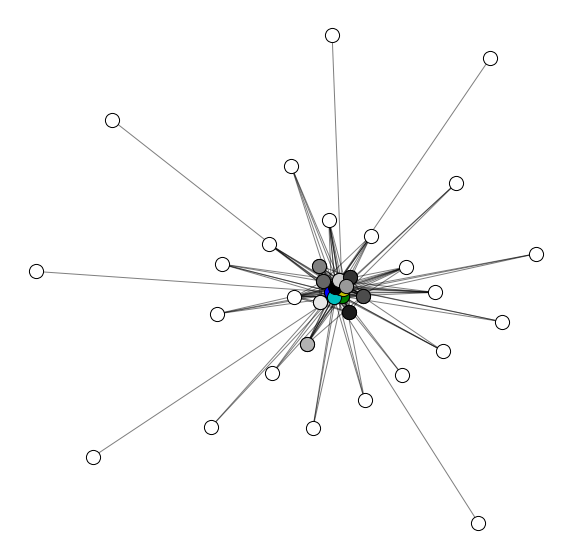

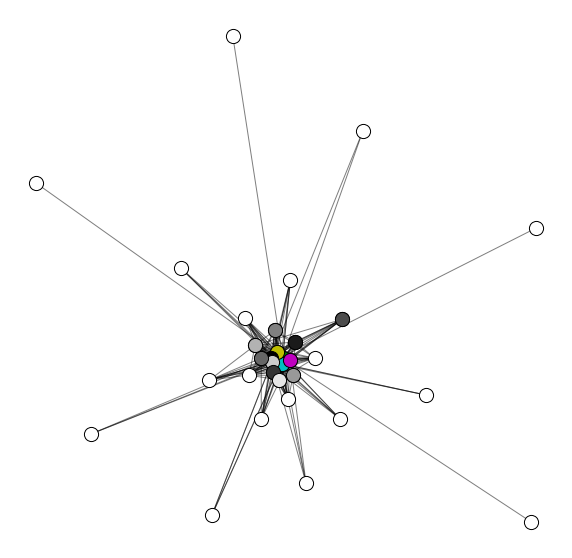

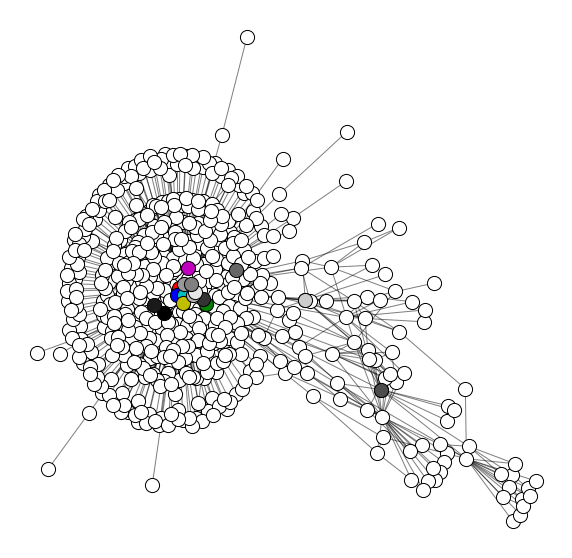

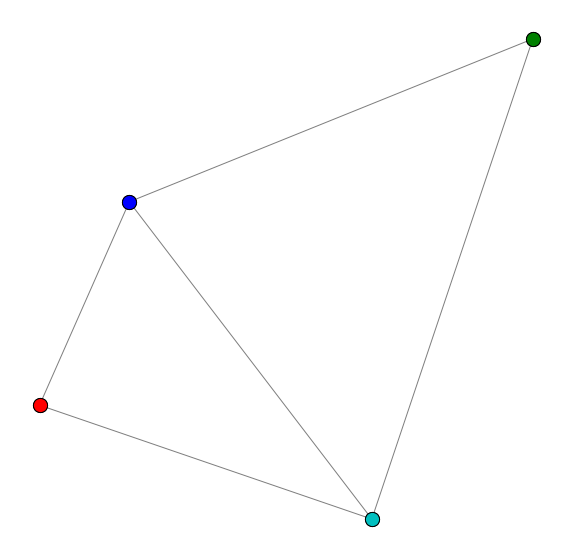

In [40]:
coms=[leiden_coms,louv_coms,lp_coms,info_coms]

for i in range(len(coms)):
    print('Figure',i+1,'Communities with',coms[i].method_name ,'\n')
    viz.plot_community_graph(g,coms[i], figsize=(10, 10))
     

### Plot the communities  top_k=10 and with label

Figure 1 Communities with Leiden 

Figure 2 Communities with Louvain 

Figure 3 Communities with Label Propagation 

Figure 4 Communities with DEMON 

Figure 5 Communities with Infomap 



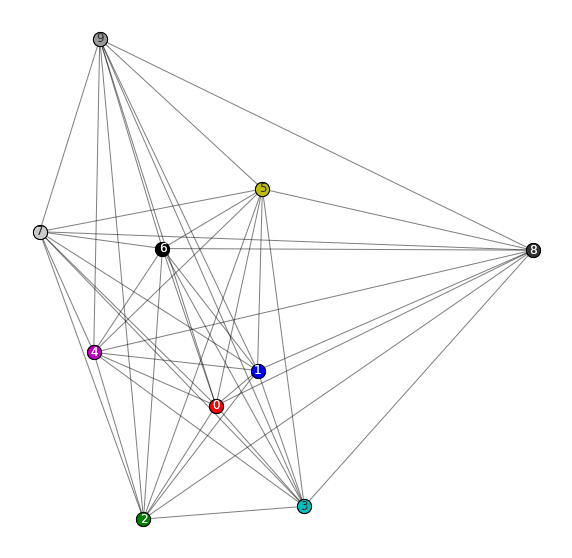

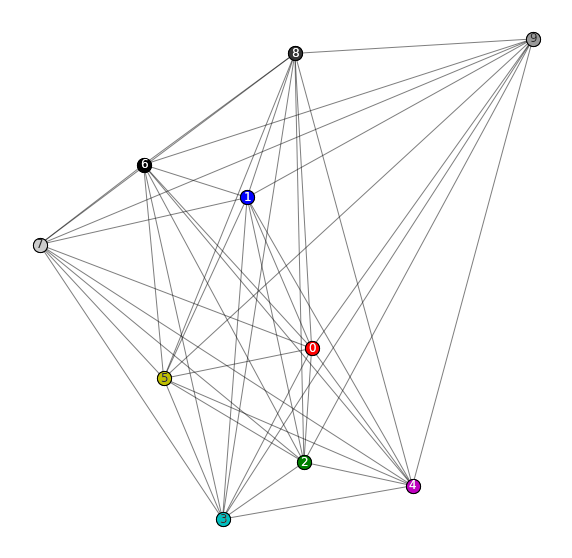

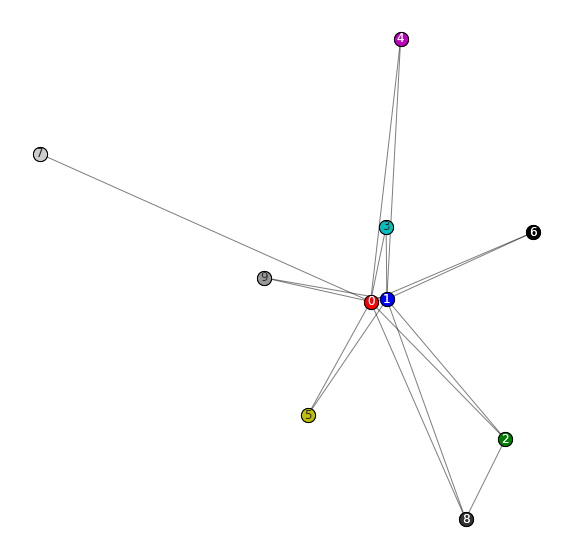

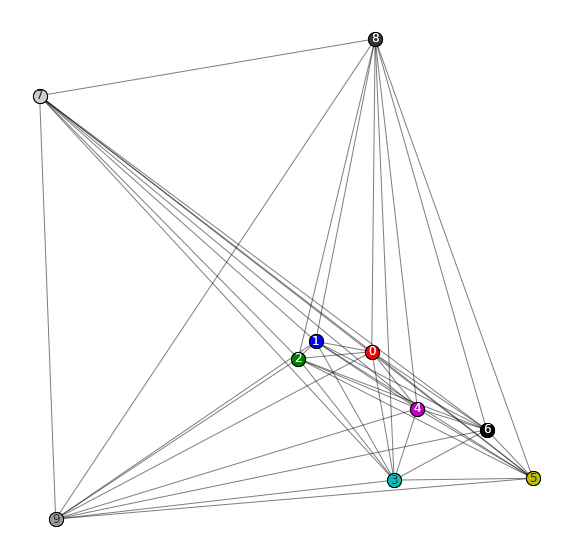

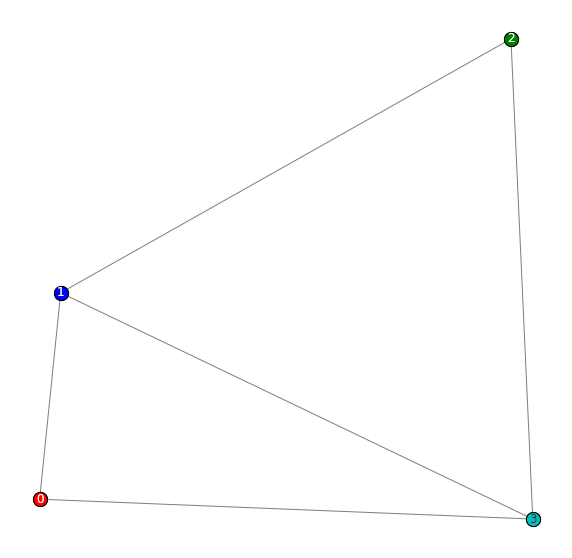

In [41]:
coms=[leiden_coms,louv_coms,lp_coms,demon_coms,info_coms]

for i in range(len(coms)):
    
    print('Figure',i+1,'Communities with',coms[i].method_name ,'\n')
    viz.plot_community_graph(g,coms[i], figsize=(10, 10),
                        plot_labels=True,top_k=10)


Such strategy is feasible when the network is small enogh. In case of medium size graphs an alternative is collapsing all community nodes into a single met-node and visualize the resulting community graph:

### Community fitness/comparison visualization

Given one (or more) clustering it could be useful to visualize how a given fitness function distributes over the communities.

A nice way to do so is by using violin plots.

In [42]:
from cdlib import viz

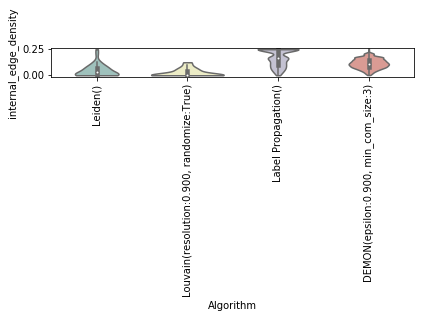

In [43]:
viz.plot_com_stat([leiden_coms,louv_coms, lp_coms,demon_coms],evaluation.internal_edge_density)

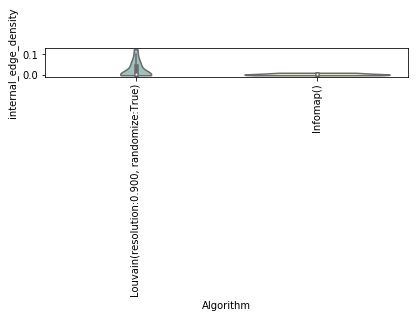

In [44]:
viz.plot_com_stat([louv_coms, info_coms],evaluation.internal_edge_density)

Another simple visualization type that allows getting a few insights on community characteristics is the scatter plot.

We can easily pair-wise compare fitness functions for one or more clustering as follows:

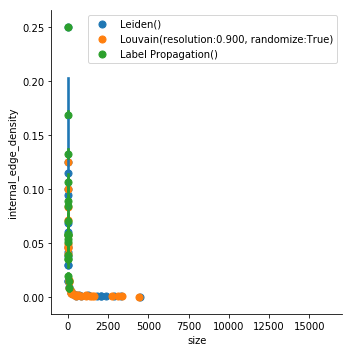

In [45]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)

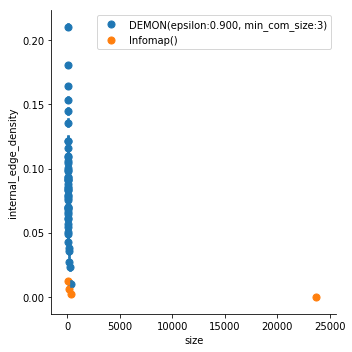

In [46]:
viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.size, evaluation.internal_edge_density)

<a id="qualitative"></a>
### Qualitative evaluation ([to top](#top))

Another way to validate a clustering is to analyse the purity of each community w.r.t. an external attribute.

In our example, let's consider the Houses of GoT characters: what's the CD approach among the tested ones that allows to identify more "homogeneous" clusters?

##### Modularity Evaluation

In [47]:
# Modularity evaluation
from cdlib import evaluation
leiden_mod=[]
louv_mod=[]
lp_mod=[]

leiden_mod=evaluation.erdos_renyi_modularity(g,leiden_coms, summary=False)
louv_mod=evaluation.erdos_renyi_modularity(g,louv_coms)
lp_mod=evaluation.erdos_renyi_modularity(g,lp_coms)
demon_mod=evaluation.erdos_renyi_modularity(g,demon_coms)
info_mod=evaluation.erdos_renyi_modularity(g,info_coms)
print('Leiden Mod\n',leiden_mod,'\n')
print('Louv Mod\n',louv_mod,'\n')
print('Label Propagation Mod\n',lp_mod,'\n')
print('Demon Mod\n',demon_mod, '\n')
print('Infomap Mod\n',info_mod, '\n')


Leiden Mod
 FitnessResult(min=None, max=None, score=-0.015263249270255314, std=None) 

Louv Mod
 FitnessResult(min=None, max=None, score=-0.014230223975880432, std=None) 

Label Propagation Mod
 FitnessResult(min=None, max=None, score=-0.2019828366288146, std=None) 

Demon Mod
 FitnessResult(min=None, max=None, score=0.6322666656440429, std=None) 

Infomap Mod
 FitnessResult(min=None, max=None, score=-0.47001750854108576, std=None) 



#### Newman Girvan Modularity 

In [48]:
# Modularity  density evaluation
leiden_mod=[]
louv_mod=[]
lp_mod=[]

leiden_mod=evaluation.newman_girvan_modularity(g,leiden_coms, summary=False)
louv_mod=evaluation.newman_girvan_modularity(g,louv_coms)
lp_mod=evaluation.newman_girvan_modularity(g,lp_coms)
demon_mod=evaluation.newman_girvan_modularity(g,demon_coms)
info_mod=evaluation.modularity_density(g,info_coms)
print('Leiden Mod\n',leiden_mod,'\n')
print('Louv Mod\n',louv_mod,'\n')
print('Label Propagation Mod\n',lp_mod,'\n')
print('Demon Mod\n',demon_mod, '\n')
print('Infomap Mod\n',info_mod, '\n')


Leiden Mod
 FitnessResult(min=None, max=None, score=0.03492892594136934, std=None) 

Louv Mod
 FitnessResult(min=None, max=None, score=0.03467286012148396, std=None) 

Label Propagation Mod
 FitnessResult(min=None, max=None, score=0.02215715553272978, std=None) 

Demon Mod
 FitnessResult(min=None, max=None, score=0.0016952632200277103, std=None) 

Infomap Mod
 FitnessResult(min=None, max=None, score=-6.779932604394148, std=None) 



#### Conduttance evaluation

In [49]:
# Conduttance evaluation

leiden_cond=evaluation.conductance(g,leiden_coms)# Modularity evaluation
louv_cond=evaluation.conductance(g,louv_coms)
lp_cond=evaluation.conductance(g,lp_coms)
demon_cond=evaluation.conductance(g,demon_coms)
info_cond=evaluation.conductance(g,info_coms)
print('Leiden Conductance\n',leiden_cond,'\n')
print('Louvain Conductance\n',louv_cond,'\n')
print('Label Propagation Conductance Mod\n',lp_cond,'\n')
print('Demon Conductance\n',demon_cond, '\n')
print('Infomap Mod\n',info_cond, '\n')



Leiden Conductance
 FitnessResult(min=0.10204081632653061, max=0.873015873015873, score=0.6175076051791872, std=0.2101478404234749) 

Louvain Conductance
 FitnessResult(min=0.10204081632653061, max=0.8919146290166243, score=0.6634851450535503, std=0.22480708234653685) 

Label Propagation Conductance Mod
 FitnessResult(min=0.06382978723404255, max=0.9130434782608695, score=0.531918132904724, std=0.19207288571282075) 

Demon Conductance
 FitnessResult(min=0.2857142857142857, max=0.9993564165272236, score=0.9806278442626982, std=0.040260527973511616) 

Infomap Mod
 FitnessResult(min=0.02766798418972332, max=0.7138137466775965, score=0.28371818758632394, std=0.2616576515951629) 



### Compare the clusters


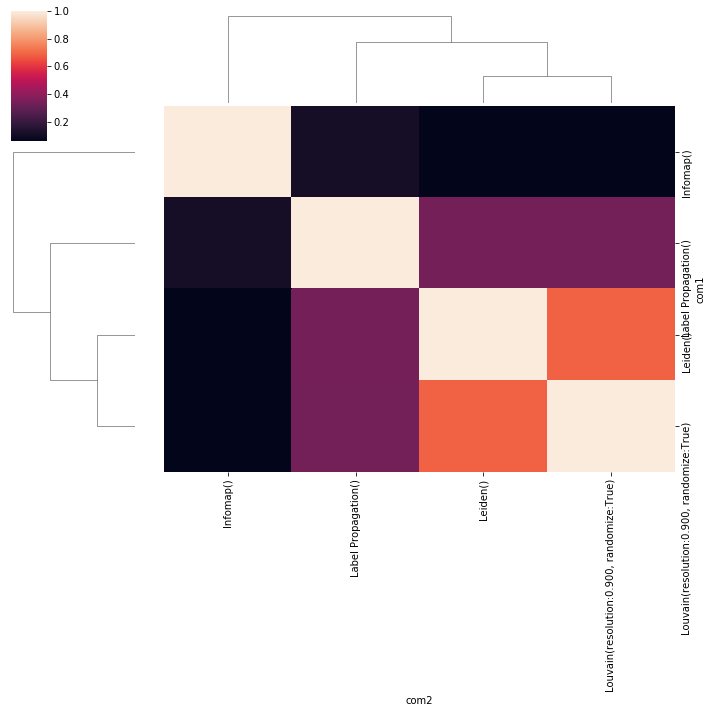

In [50]:
from cdlib import algorithms, viz, evaluation

clustermap = viz.plot_sim_matrix([leiden_coms,louv_coms, lp_coms,info_coms],evaluation.adjusted_mutual_information)

<a id="gt"></a>
### Ground Truth evaluation ([to top](#top))

Let assume we want to compare different clusterings over a set of network ground truth partitions.

In order to obtain a more interesting example, we can generate a few synthetic graphs with planted ground truth clusterings and perform CD upon them. <br/> We can easily visually compare their resuls as follows:

Returns the LFR benchmark graph for testing community-finding algorithms

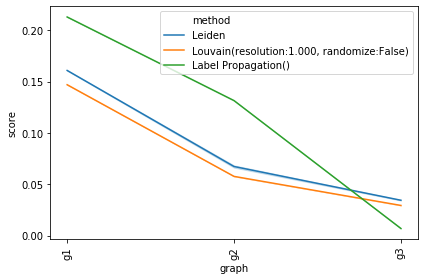

In [32]:
from cdlib import NodeClustering
from networkx.generators.community import LFR_benchmark_graph



g1 = LFR_benchmark_graph(g.number_of_nodes(), 3, 1.5, 0.5, min_community=5, average_degree=5)
g2 = LFR_benchmark_graph(g.number_of_nodes(), 3, 1.5, 0.6, min_community=5, average_degree=5)
g3 = LFR_benchmark_graph(g.number_of_nodes(), 3, 1.5, 0.7, min_community=5, average_degree=5)

names = ["g1", "g2", "g3"]
graphs = [g1, g2, g3]
references = []

# building the NodeClustering ground truth for the graphs
for g in graphs:
    ground_truth = NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference")
    references.append(ground_truth)
    
algos = [algorithms.leiden,algorithms.louvain, algorithms.label_propagation]

# Computing the visualization (2 execution per method, NMI as scoring for ground truth resemblance)
viz.plot_scoring(graphs, references, names, algos, scoring=evaluation.adjusted_mutual_information, nbRuns=2)

Finally, we can also compare different clustering obtained on the same graph by alternative algorithms among them. <br/>
Let's get back to our initial Karate Club graph and compute a few more clusterings upon it:

In [40]:
# Computing the NF1 scores and statistics
print(evaluation.nf1(louv_coms,leiden_coms))
print(evaluation.f1(louv_coms,leiden_coms))


MatchingResult(score=0.32793750000000005, std=None)
MatchingResult(score=0.6477777777777778, std=0.37796318979433197)


#### Density VS. Size

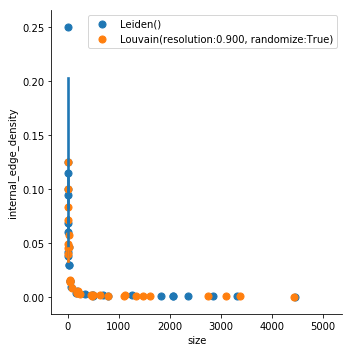

In [51]:
lmplot = viz.plot_com_properties_relation([leiden_coms,louv_coms],evaluation.size,evaluation.internal_edge_density)

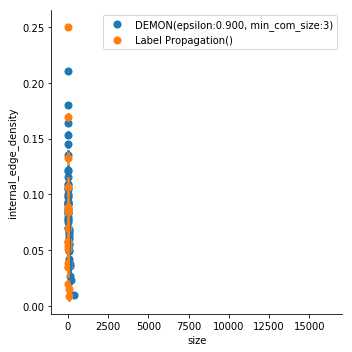

In [52]:
lmplot2 = viz.plot_com_properties_relation([demon_coms,lp_coms],evaluation.size,evaluation.internal_edge_density)

### Upload Best communities

In [54]:
from cdlib import algorithms, readwrite
readwrite.write_community_csv(leiden_coms, "leiden_coms.csv", ",")
readwrite.write_community_csv(louv_coms, "louv_coms.csv", ",")
readwrite.write_community_csv(demon_coms, "demon_coms.csv", ",")
